# Estimating SARS-Cov-2 outbreak $R_t$ by Autonomous community in Spain

# 1. Introduction <a class="anchor" id="introduction"></a>

## 1.1 Table of Contents <a class="anchor" id="table-of-contents"></a>

* [1. Introduction](#introduction)
    * [1.1 Table of Contents](#table-of-contents)
    * [1.2 Project Description](#project-description)
    * [1.3 Packages](#packages)
        * [1.3.1 Python and 3rd party libraries](#python-and-third-party-libraries)
        * [1.3.2 Custom packages](#custom-packages)
        * [1.3.3 Magic functions](#magic-functions)
        * [1.3.4 Reproducibility](#reproducibility)
* [2. Data Loading](#data-loading)
* [3. Data Exploration](#data-exploration)
* [4. Data Preprocessing](#data-preprocessing)
* [5. Modeling](#modeling)
* [6. Functions](#functions)
* [7. References](#references)
* [8. Project contribution](#project-contribution)

## 1.2 Project Description <a class="anchor" id="project-description"></a>

This notebooks intends to be an approximation of the work presented by Kevin Systrom in [**Estimating COVID-19's $R_t$ in Real-Time**](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb), who are already described the technical parts.

The objective here is applying the COVID data to **every Autonomous community in Spain** and reviewing some of the parts of the Bayesian analysis already presented in the original notebook.

I want to remark some of the ideas discussed remembering that while some epidemiologist are arguing that tracking $R_t$ is crucial to face this outbreak, this information has also limitated practical value outside the population from which the disease data originated, as Ridenhour et al., 2014 has already shown. The same authors also conclude that the application among different regions have yielded a wide range of results in past outbreaks, and the decisions taken by one country could lead suboptimal results to another country. This is why I want to remark the idea of estimating $R_t$ has to be among regions in the same country, and in any case at national level.

Interesting ideas apart from ones already showed:

- It seems to exist an understimation in the cases reported by Spain government. To adjust the detection rate could be interesting to explore some distributions in order to make the adjustment. Another idea could be compare the analysis with another country which has performed more test (e.g. Germany). Today (2020/04/16) we have seen an explosion in the number of cases in Catalonia. It can explain such a way the underestimation of the reported cases.
- Weekend reported cases seem to have different detection rates than week days. The first idea was to remove this days for the data set and change the rolling window from 7 to 5. That's not a final solution but it could be interesting to check how it is changing with the time.
- It is interesting to separate functions from the notebook and put here only the parameters to touch. It could also be useful to package them in order to run the analysis every day in an easier way.
- High Density Function (HDI) implemented by the previous author is slow. This part of the code might be optimized.
- Apply some time series techniques like serial correlations (autocorrelations) could be useful to find some patterns in a wider temporal view.

*Remember: The basic reproduction number ($R_0$) of an infection can be thought of as the expected number of cases directly generated by one case in a population where all individuals are susceptible to infection*

## 1.3 Packages <a class="anchor" id="packages"></a>

### 1.3.1 Python and 3rd party libraries <a class="anchor" id="python-and-third-party-libraries"></a>

In [3]:
import os, sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from IPython.display import clear_output

###  1.3.2 Custom packages <a class="anchor" id="custom-packages"></a>

In [6]:
sys.path.append('../')
from src import utils

### 1.3.3 Magic functions <a class="anchor" id="magic-functions"></a>

In [7]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

### 1.3.4 Reproducibility <a class="anchor" id="reproducibility"></a>

In [8]:
#### !pip install watermark
#### rasbt watermark https://github.com/rasbt/watermark
%load_ext watermark
%watermark -a 'Fernando Pozo' -u -n -t -z -g -p pandas,numpy,matplotlib

!pwd

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
# plt.style.use('ggplot')

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Fernando Pozo 
last updated: Thu Apr 16 2020 19:41:19 CEST 

pandas 1.0.3
numpy 1.18.1
matplotlib 3.2.1
Git hash: cde1ee8cee7617992281676b5a144db894ddfecb
/local/fpozoc/MEGA/projects/covid-rt/notebooks


# 2. Data Loading <a class="anchor" id="data-loading"></a>

Spain source data from https://covid19.isciii.es/

In [9]:
df_spain, s_spain, t_spain = utils.get_data('https://covid19.isciii.es/resources/serie_historica_acumulados.csv', country='spain')
df_usa, s_usa, t_usa = utils.get_data('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv', country='usa')

# 3. Modeling <a class="anchor" id="modeling"></a>

## 3.1 Setting model parameters

In [32]:
# We create an array for every possible value of Rt
# r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
# Gamma is 1/serial interval
# serial interval is 3.96
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article

###
R_T_MAX = 12
ROLLING = 'median'
PRIOR = 'gamma'
GAMMA = 1/3.96
WINDOW = 7
MIN_PERIODS = 1
ALPHA = 0.05
###

REGION = 'Cataluña'
df_cases = df_spain
s_cases = s_spain
t_cases = t_spain

ncols = 3
nrows = int(np.ceil(len(t_cases) / ncols))

In [11]:
s_original, s_smoothed = utils.prepare_cases(s_cases.xs(REGION), rolling = ROLLING, rolling_window=WINDOW)
df_posteriors = utils.get_posteriors(s_smoothed, prior = PRIOR, window=WINDOW, min_periods=MIN_PERIODS, gamma=GAMMA, r_t_max=R_T_MAX)
df_r0s = pd.concat([df_posteriors.idxmax().rename('ML'), utils.highest_density_interval(df_posteriors)], axis=1)

# 4. Visualization <a class="anchor" id="data-preprocessing"></a>

## 4.1 Daily cases

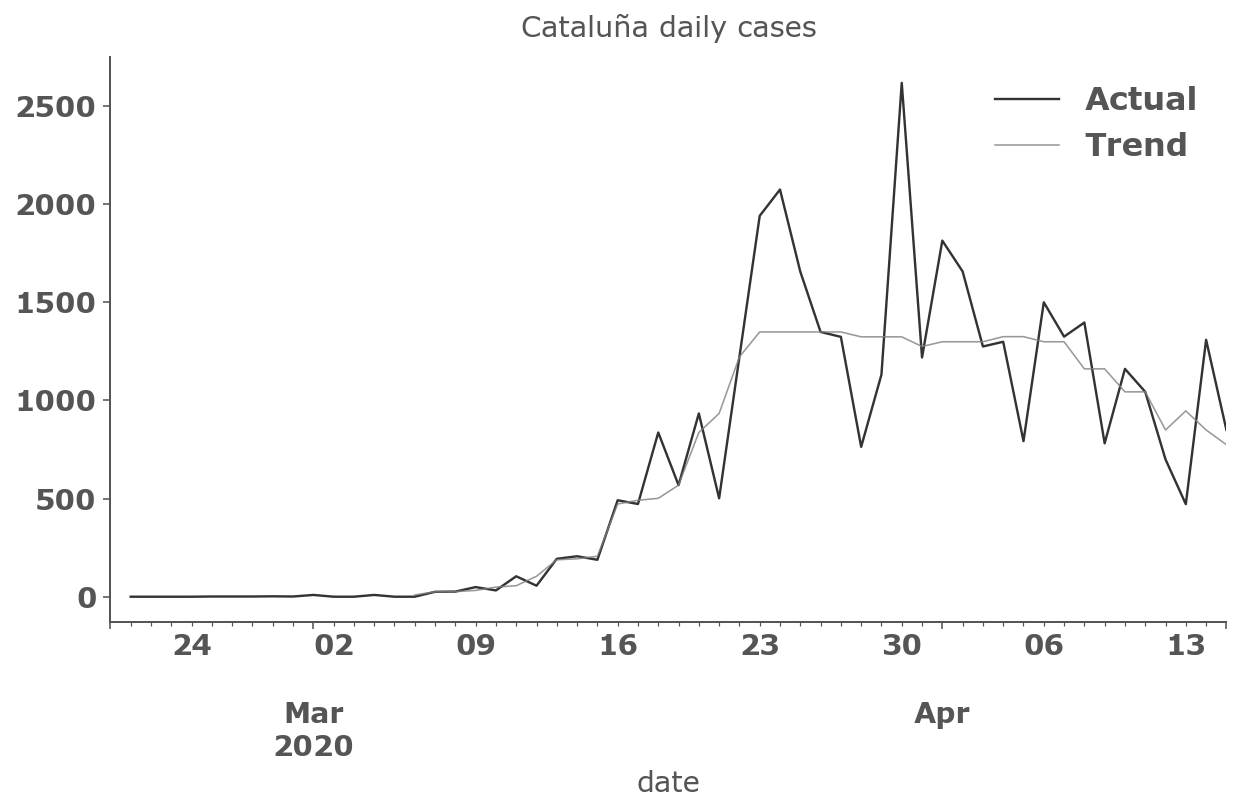

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
utils.plot_daily_cases(s_original, s_smoothed, ax, REGION)

## 4.2 Density function of the posterior probability of $R_t$

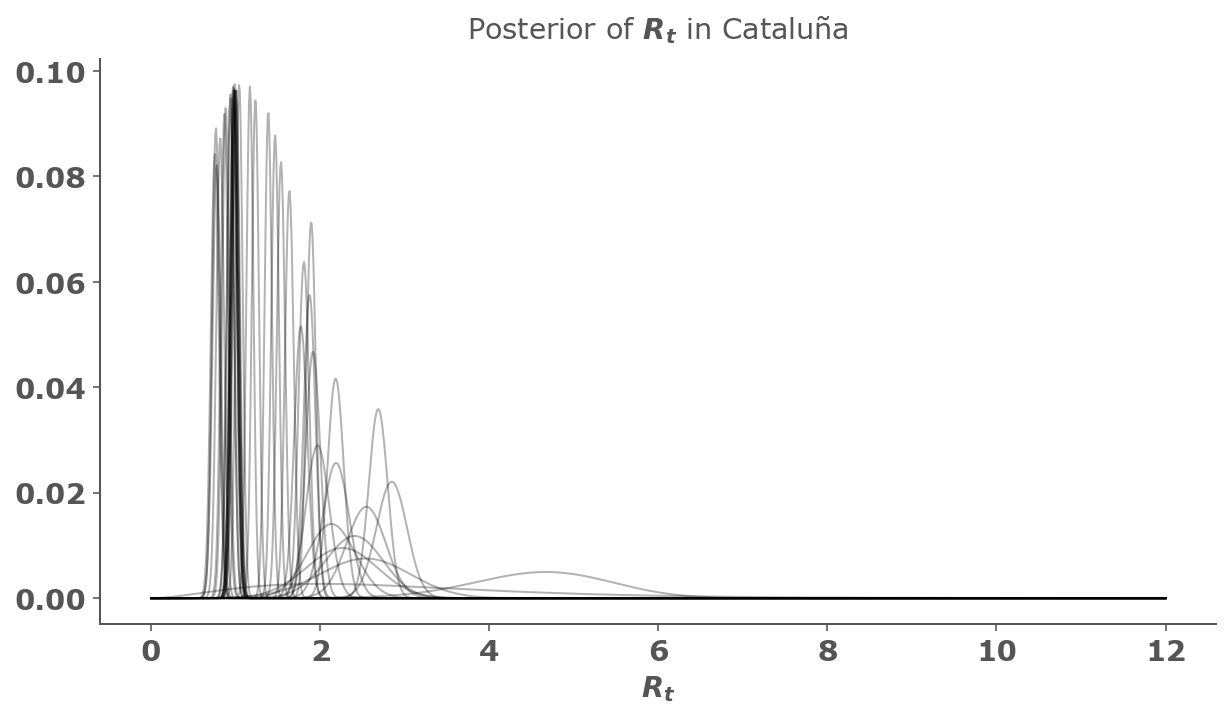

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
utils.plot_posteriors(df_posteriors, ax, REGION)

## 4.3 $R_t$ estimation over the outbreak

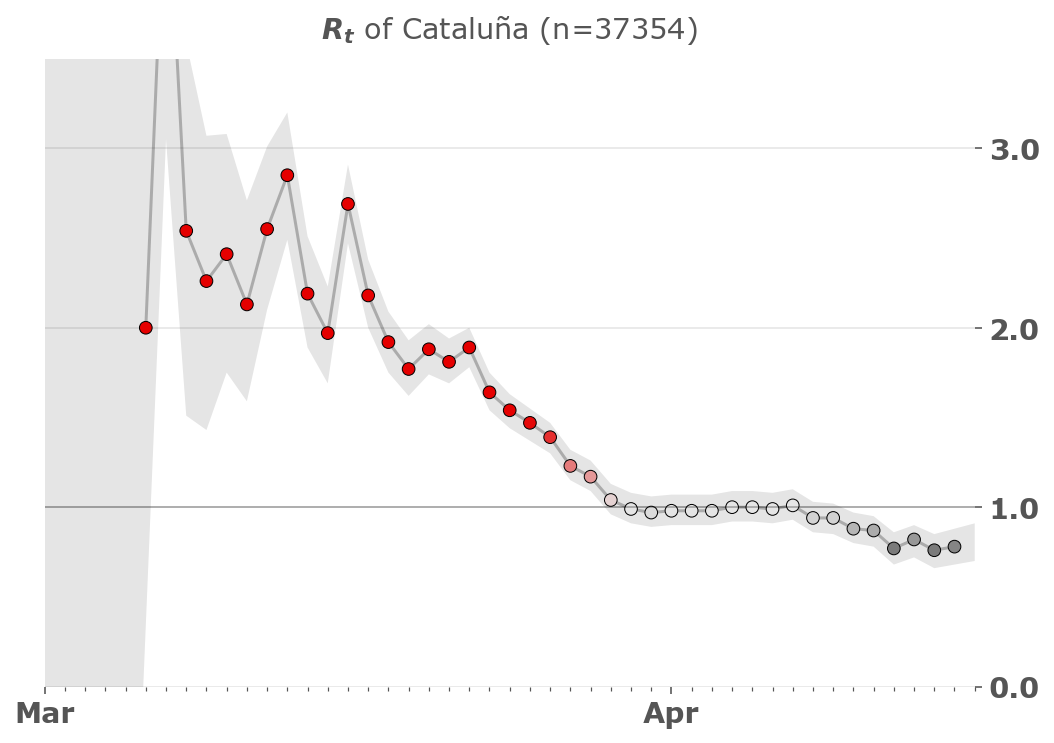

In [29]:
fig, ax = plt.subplots(figsize=(600/72,400/72))
utils.plot_rt(df_r0s, ax, t_cases, REGION)

## 4.4 Model report

In [30]:
originals = {}
smootheds = {}
r0s = {}
posteriors = {}
for region, cases in s_cases.groupby(level='region'):
    clear_output(wait=True)
    print(f'Processing {region}')
    s_original, s_smoothed = utils.prepare_cases(s_cases.xs(region), rolling_window=WINDOW)
    print('\tGetting Posteriors')
    try:
        df_posteriors = utils.get_posteriors(s_smoothed, prior = 'gamma', window=WINDOW, min_periods=MIN_PERIODS, gamma=GAMMA, r_t_max=R_T_MAX)
    except:
        display(cases)
    print('\tGetting most likely values')
    df_r0s = pd.concat([df_posteriors.idxmax().rename('ML'), utils.highest_density_interval(df_posteriors)], axis=1)
    originals[region] = s_original
    smootheds[region] = s_smoothed
    posteriors[region] = df_posteriors
    r0s[region] = df_r0s
clear_output(wait=True)
print('Done.')

Done.


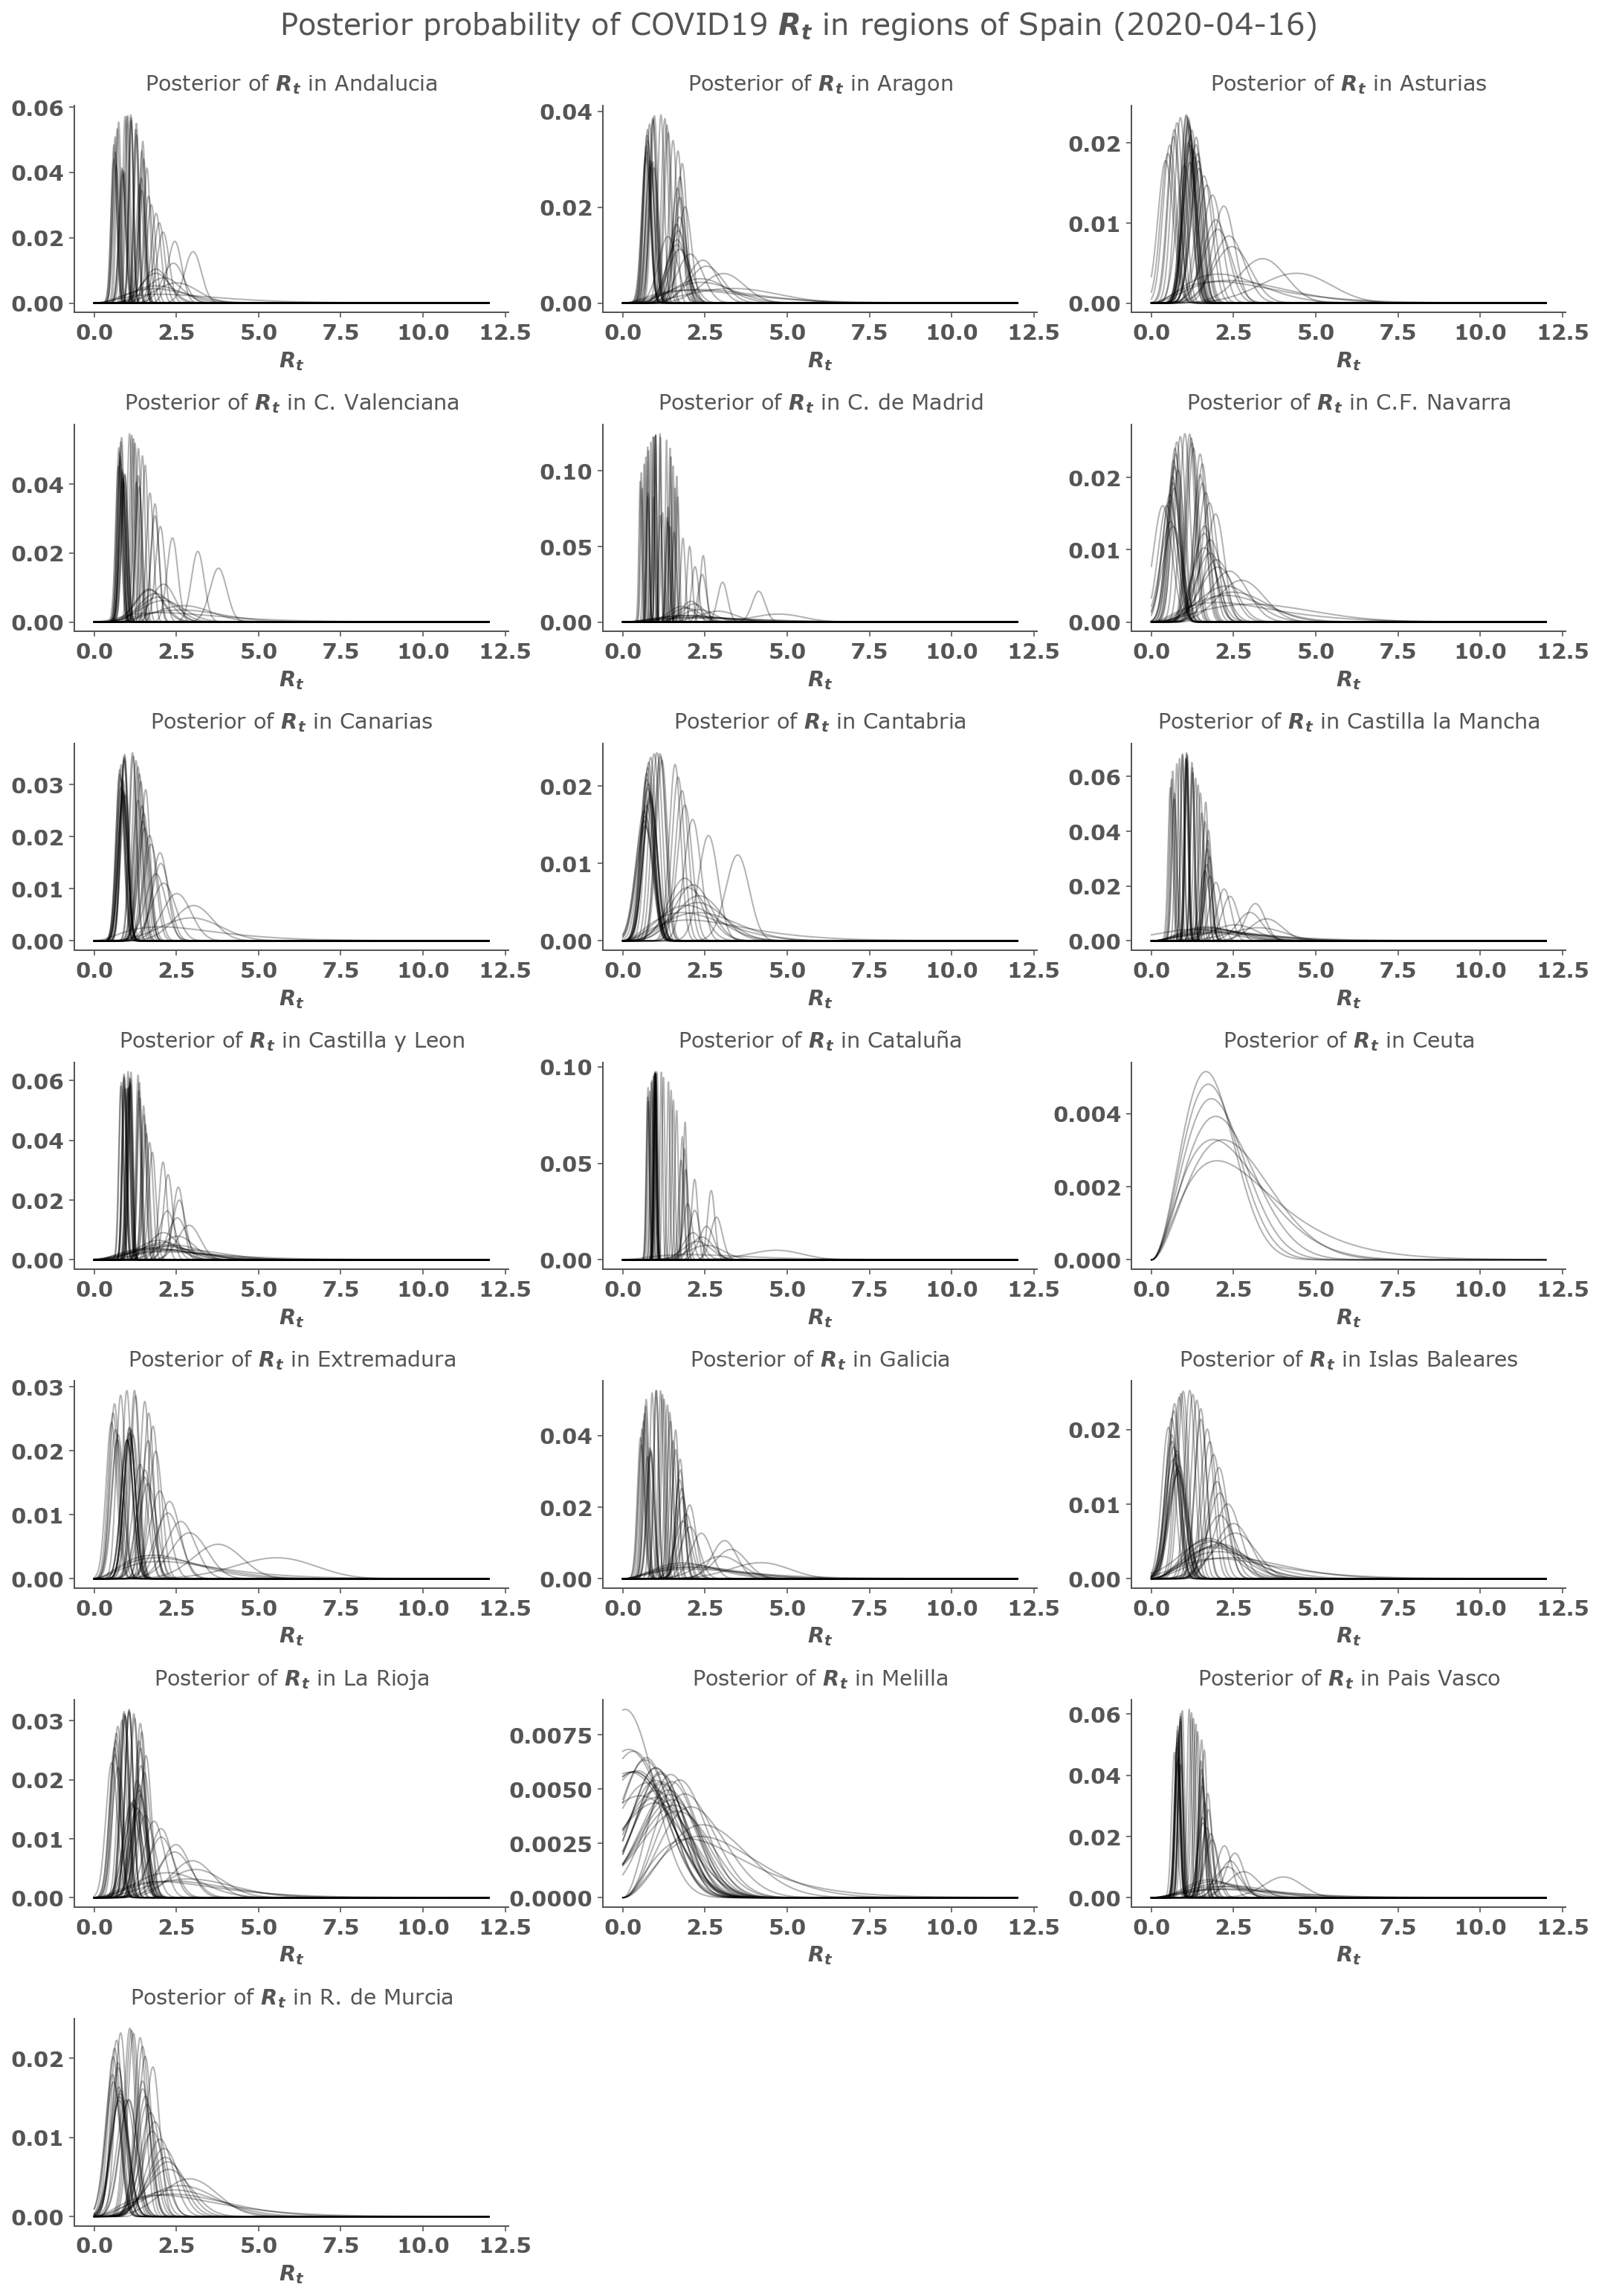

In [58]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig.suptitle(f'Posterior probability of COVID19 $R_t$ in regions of Spain ({date.today()})', fontsize=20, y=1.02)
for i, (region, result) in enumerate(posteriors.items()):
    utils.plot_posteriors(result, axes.flat[i], region)
fig.tight_layout()
fig.delaxes(axes[-1][-1])
fig.delaxes(axes[-1][-2])
fig.savefig('../reports/figures/posterior_covid19_rt_per_aacc.png')

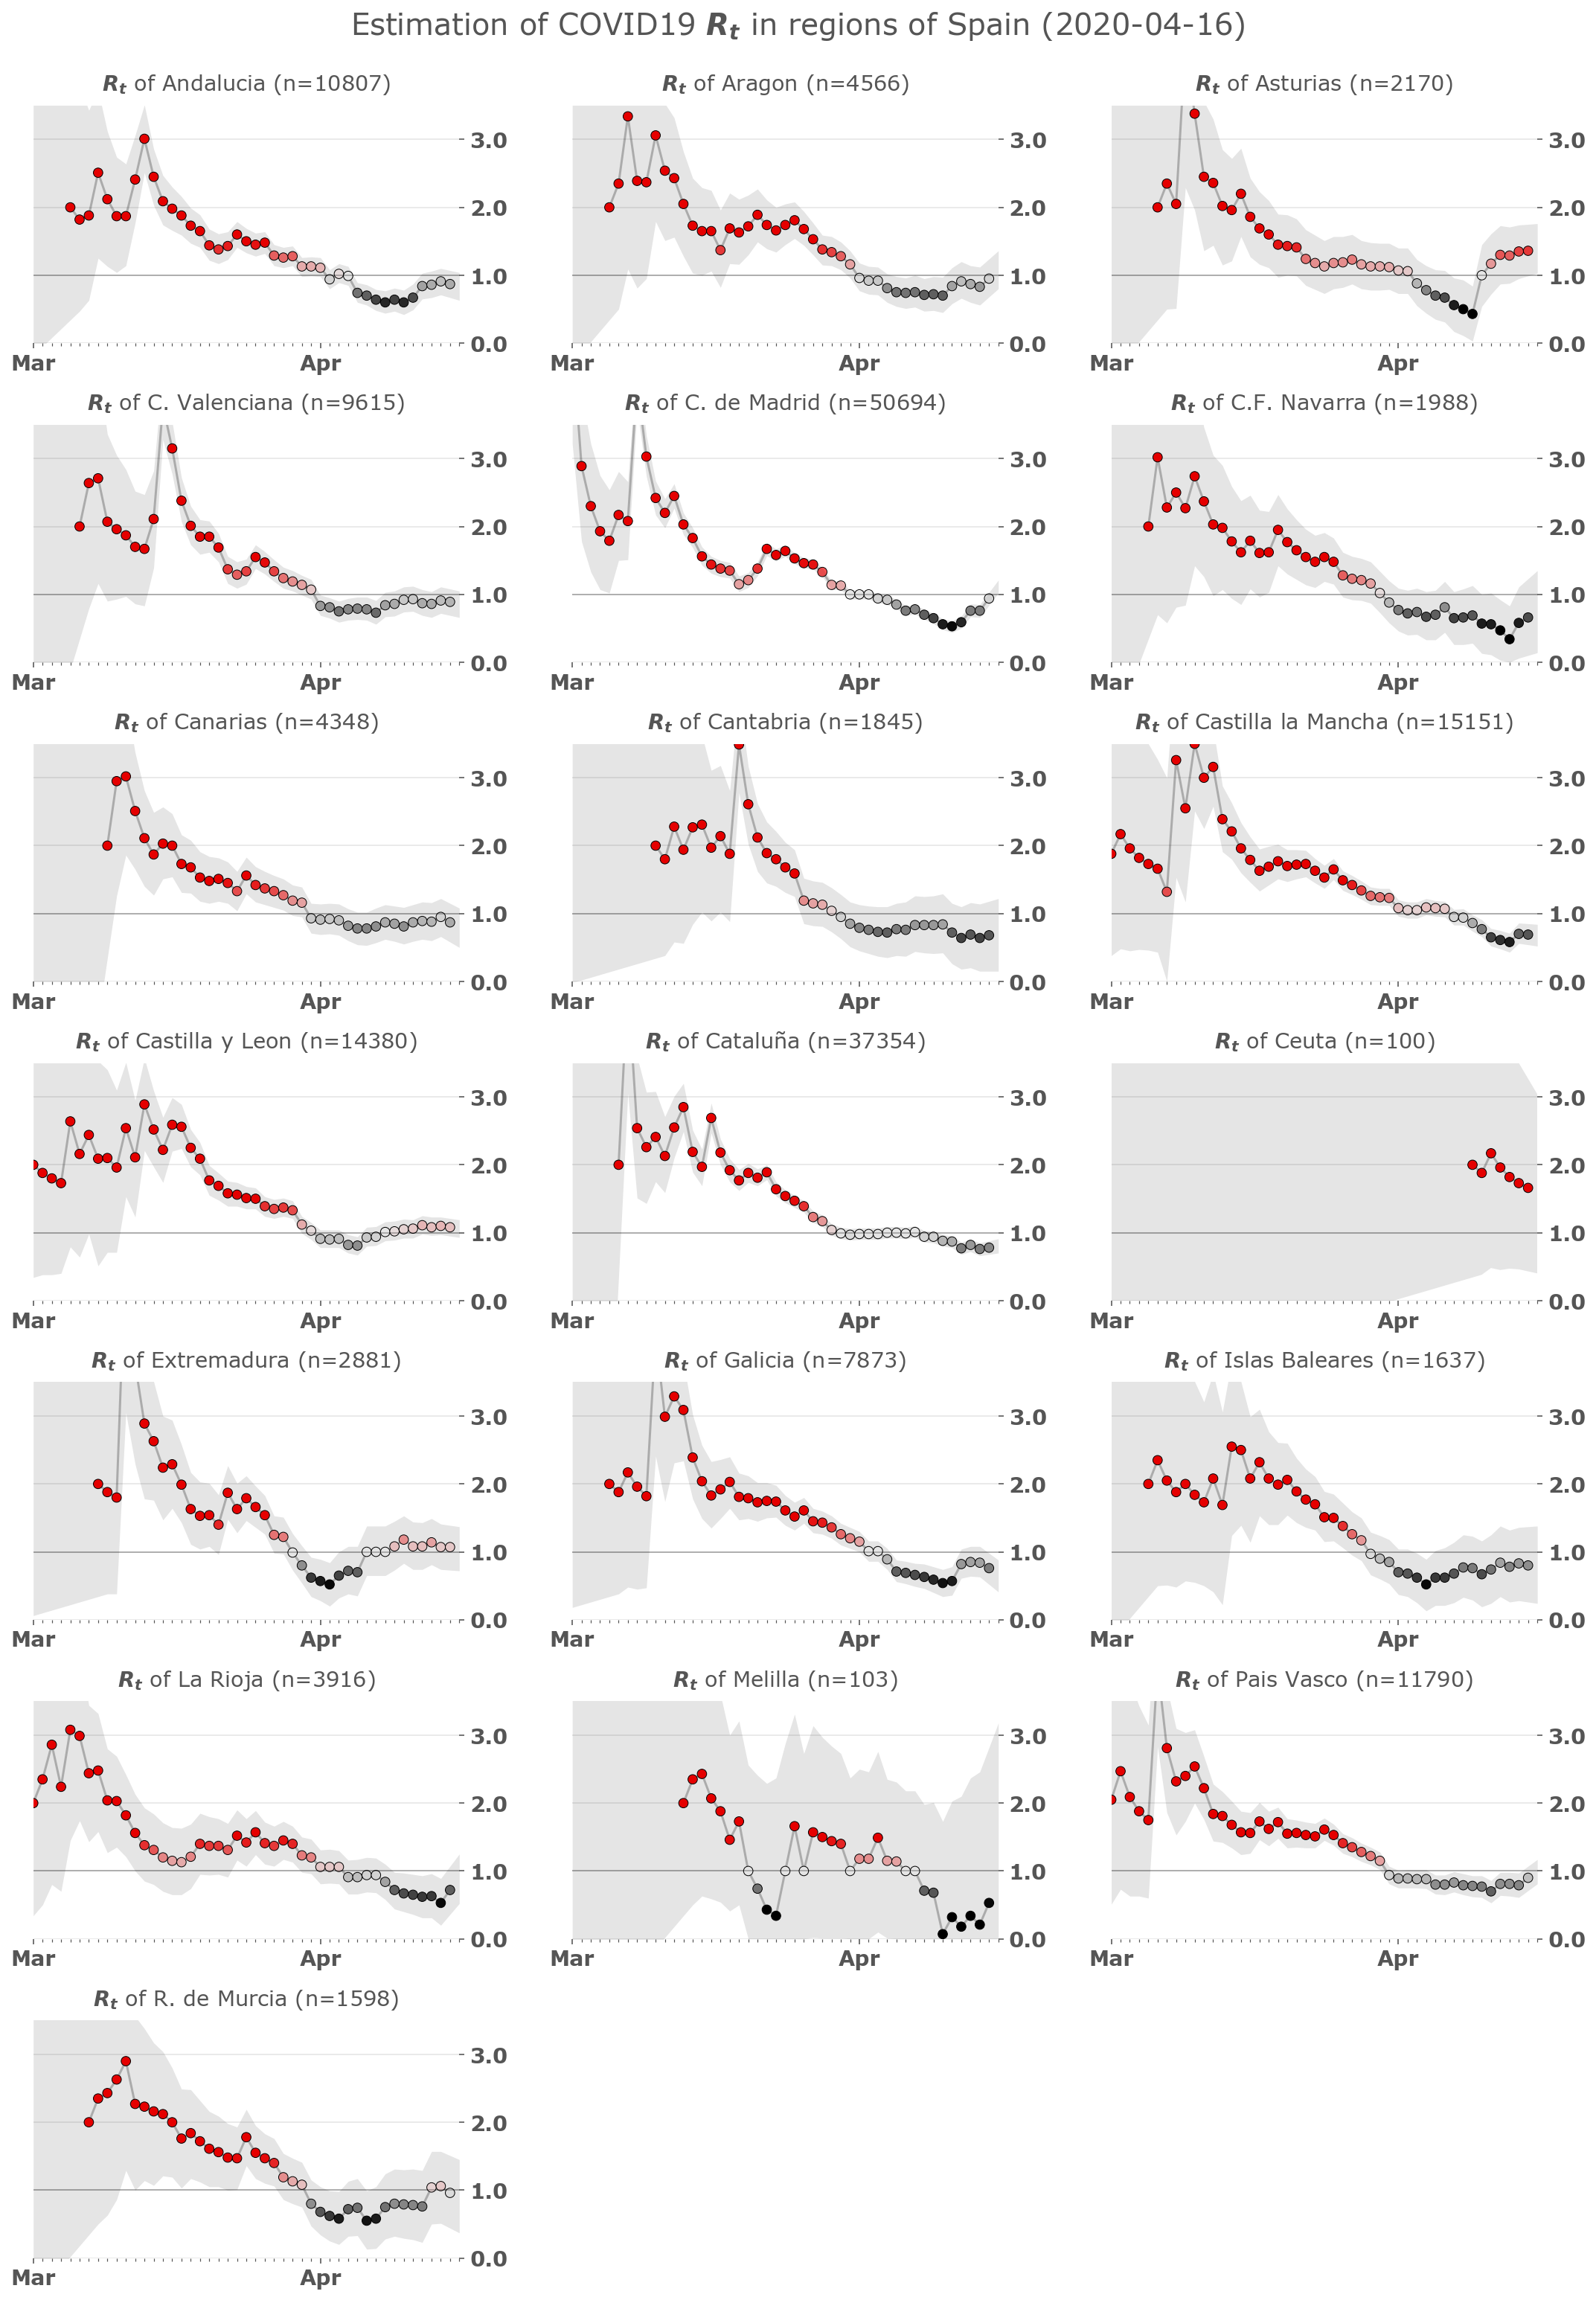

In [59]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig.suptitle(f'Estimation of COVID19 $R_t$ in regions of Spain ({date.today()})', fontsize=20, y=1.02)
for i, (region, result) in enumerate(r0s.items()):
    utils.plot_rt(result, axes.flat[i], t_cases, region)
fig.tight_layout()
fig.delaxes(axes[-1][-1])
fig.delaxes(axes[-1][-2])
fig.savefig('../reports/figures/estimation_covid19_rt_per_aacc.png')

# 5. References <a class="anchor" id="references"></a>

- *Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases*, by Bettencourt and Ribeiro, 2008. [Link](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185)
- *Unraveling R0: Considerations for Public Health Applications*, by Ridenhour et al., 2014. [Link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3935673/)

# 6. Project contribution <a class="anchor" id="project-contribution"></a>

**Author information**:
Fernando Pozo ([@fpozoc](https://gitlab.com/fpozoc))

You can find the data driven project jupyter notebook template [here](https://gitlab.com/fpozoc/data-driven-project-template/-/blob/master/notebooks/1.0-nb_template.ipynb).